# 10. Deep Learning Lab (2024 edition)

In this tutorial we will work with various neural network model architectures and demonstrate their use for various tasks.

- First, we will construct and train an [MLP with a single hidden layer for a regression task](#scrollTo=A_regression_exercise_with_a_MLP_and_the_Hitters_dataset). We will predict the salery of athletes using the Hitters dataset. We will also compare with linear regression models, that we have seen previously in the class.

- Second, we will work on a [multi-layer network for a classification task](#scrollTo=Multilayer_Network_with_the_MNIST_dataset) for recognizing hand-written images. Here we will classify images to detect handwritten numbers (0-9), with the classical MNIST dataset.

- Third, we will study a more difficult classification task that involves 100 classes! We will construct and train a [Convolutional Neural Network for image classification](#scrollTo=Convolutional_Neural_Networks_with_the_CIFAR_dataset) using the CIFAR image dataset.

- Fourth, we will use a [Pre-trained CNN for classifying our own images](#scrollTo=Pretrained_CNN_model_for_image_classification). We will re-use a deep CNN architecture with 50-layers, called ResNet50!

- Last, we will conclude with a challenge for you: Using the knowledge of this tutorial, create your own model, and improve results for the hardwritten digit recogrition problem, using MNIST!


In this section, we demonstrate how to fit neural networks using the examples discussed in the ISLR book text.

We use the `keras` package, a multi-framework package for deep learning, that is compatible with any framework – JAX, TensorFlow, or PyTorch. If you want to know more, visit the [keras website](https://www.keras.io), it has a very comprehensive documentation.

A good companion
is the textbook *Deep Learning with Python*
(F. Chollet, 2017, Manning Publications,) and most of our code has been inspired from there.

Getting `keras` up and running on your computer can be a
challenge.

Therefore, we will with colab, that come prepackaged with everything necessary!

In [ ]:
# Import several libraries that we will use below
import numpy as np
import pandas as pd
import sklearn
import keras

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression , LogisticRegression , Lasso
from sklearn.metrics import mean_absolute_error, r2_score
from keras import layers, Sequential

from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.applications.resnet import ResNet50

import os
import matplotlib.pyplot as plt
import seaborn as sns

## 1. A regression exercise with a MLP and the Hitters dataset



Here we will revisit the examples of Section *10.6 When to Use Deep Learning*, and develop a regression model for the Hitters dataset from Chapter 6.

This is a regression problem, where the goal is to predict the 'Salary' of a baseball player in 1987 using his performance statistics from 1986. After removing players with missing responses, we are left with 263 players and 19 variables. We randomly split the data into a training set of 176 players (two thirds), and a test set of 87 players (one third). We used three methods for fitting a regression model to these data.

- A linear model was used to fit the training data, and make predictions on the test data. The model has 20 parameters.
- The same linear model was fit with lasso regularization.
- A MLP neural network with one hidden layer consisting of 64 ReLU units was fit to the data. This model has 1,345 parameters.

Lets get started, download the Hitters dataset, load it, and inspect it.
Then we will turn the cetegorical attributes into numerical with one hote encoding, and split it in training and test. Test set is a random 33% of the original dataset.

We will also scale the dataset using a standard scaler.

All these steps should be sraightforward to you from the previous lessons, so quickly we will move into fitting and evaluating linear models!

In [ ]:
# Download the Hitter's dataset
!wget -q https://git.wur.nl/koots006/msc-course-machine-learning/-/raw/0ffcf25692d63933a03c092b79ba9906b8576058/islr_data/Hitters.csv

In [ ]:
# Load the dataset
hitters = pd.read_csv('Hitters.csv')
hitters.head()
hitters=hitters.dropna()

In [ ]:
#Inspect the dataset
hitters.head(5)

In [ ]:
# Preprocessing: encode categorical variables with one hot encoding
ohe = OneHotEncoder(sparse_output=False,drop="if_binary")
hitters[['League', 'Division', 'NewLeague']] = ohe.fit_transform(hitters[['League', 'Division', 'NewLeague']])

In [ ]:
# features and target variables
X = hitters.loc[:, hitters.columns != 'Salary']
y = hitters.Salary

In [ ]:
# Split train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=0)

In [ ]:
# Scale the dataset
scaler = StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### A feed-forward neural network with a single hidden layer
Here we will define and train a simple neural network using keras.

#### Model structure

First, we define the neural network model structure to have one hidden layer consisting of 64 neurons, using the RELU activation function.

In keras,  we create feed-forward models, ie with several layers in a sequence, with the `Sequential` class.

- The first layer is an input layer, with the shape of the input data!
- Then, comes a "dense" layer of 64 neurons, and RELU activations.
- It is followed by a Dropout layer (for regularization) of 20%
- Finally the output layer predicts the target salary. As it is a regression task, we use a linear activation function here.

In [ ]:
# Define the model structure
mlp = Sequential([
                  layers.Input(shape=X_train.shape[1]),
                  layers.Dense(units=64, activation='relu'),
                  layers.Dropout(rate=0.2),
                  layers.Dense(units=1, activation='linear'),
                ])


To inspect the structure and the number of parameters of the model we can use the `summary` function.

In [ ]:
# Check the structure
mlp.summary()

Our model structure is ready. Next we need to configure it for training.


#### Training configuration

This involves setting a loss function, and metrics to compute during training.

In our case, we select MSE for the loss function, and additionally report MAE and R2 score, so that we can monitor the training process.

We also define the optimizer that is used for minimizing the loss function of a neural network during training. It also updates the model weights and biases based on the gradients of the loss function. Here we use RMSprop, an extention to Stochastic Gradient Descent, that works more effciently.


In [ ]:
# set things up
mlp.compile(loss='mse', metrics=['mae', 'R2Score'], optimizer='rmsprop')

Now, we are ready to train (aka fit) the MLP model.

#### Model training

For this, we will pass the training data (features and labels), define the number of epochs (ie training iterations), and the bath size.

We will use 10% of the training data for model validation during training.

Once you execute the cell below you will see printouts of the trianing process, reporting on the three metrics we have defined above:
(a) loss, which is MSE,
(b) MAE, and
(c) R2.

Metrics are reported both for the training, and the validation split!



In [ ]:
history = mlp.fit(X_train,
                    y_train,
                    epochs=600,
                    batch_size=16,
                    validation_split=0.1,
                    )

#### Monitoring the training process

We will visualize the model training process, and see how these metrics evolve during

In [ ]:
# Plot loss (MSE) for both training and validation split

sns.lineplot(x=history.epoch, y=history.history['loss'], color='g', label='training')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], color='b', label='validation')
plt.title('Model loss during training')
plt.ylabel('loss')
plt.xlabel('training epoch')
plt.legend(loc='upper right')

In [ ]:
# Plot R2 for both training and validation split

sns.lineplot(x=history.epoch, y=history.history['r2_score'], color='g', label='training')
sns.lineplot(x=history.epoch, y=history.history['val_r2_score'], color='b', label='validation')

plt.title('R2 during training')
plt.ylabel('R2')
plt.xlabel('epoch')
plt.legend(loc='lower right')

> ##### **Discussion question**
>
> - What can you tell from inspecting the training diagrams? Does the MLP overfit, or underfit?

#### Evaluate with the independent test set

In [ ]:
y_hat_test = mlp.predict(X_test)
print("MAE",mean_absolute_error(y_test, y_hat_test))
print("R2",r2_score(y_test, y_hat_test))

> ##### **Discussion question**
>
>
> - How does the model perform in the test set?
> - How does this compare with the metrics you estimated in the training and validation splits?

### Compare with (linear) machine learning models

We will fit and evaluate two models for the same task: A linear regressor, and a linear regressor with lasso regularization.

We will report MAE and R2 on the holdout test set. Note and compare the metrics with the Neural Network above.

#### Linear regression model

In [ ]:
# Linear regression model
lrm = LinearRegression()\
        .fit(X_train, y_train)

#estimate metrics on the training set
y_hat_train = lrm.predict(X_train)
print("MAE LRM training",mean_absolute_error(y_train, y_hat_train))
print("R2 LRM training", r2_score(y_train, y_hat_train))


In [ ]:
#estimate metrics on the test set

y_hat_test = lrm.predict(X_test)
print("MAE",mean_absolute_error(y_test, y_hat_test))
print("R2",r2_score(y_test, y_hat_test))

> ##### **Discussion question**
>
> - Can you explain how many parameters are in this model?
>
> (hint) Use `lrm.coef_` to view the model parameters

#### Lasso regularization
Repeat the same for Lasso!

In [ ]:
# Lasso training
lasso = Lasso(max_iter=3000)\
             .fit(X_train, y_train)

#estimate metrics on the training set
y_hat_train = lasso.predict(X_train)
print("MAE Lasso training",mean_absolute_error(y_train, y_hat_train))
print("R2 Lasso training", r2_score(y_train, y_hat_train))

In [ ]:
y_hat_test  = lasso.predict(X_test)
print("MAE Lasso",mean_absolute_error(y_test, y_hat_test))
print("R2 Lasso",r2_score(y_test, y_hat_test))

> ##### **Question and Exercise**
>
>- How many parameters are in this model?
>
> Note that we did not do tune the model for the hyperparameter ($\lambda$), as mentioned in the book. If you have time at the end of today, you can do so by 10-fold cross-validation on the training data. The optimized model comes with 12 variables having nonzero coefficients.

> ##### **Discussion question**
>
>
> - Make a table that reports MAE for the three models you have constructed for both training and test split.
> - The MLP performs better metrics compared to the linear models. Is it indeed better than them? How can you measure that?


> ##### **Extra exercise**: Compare to a Random Forest
>
> *(If you have time left, at the end of the day)*
>
> - Fit a Random Forest on the regression exercise.
> - What are your results?
> - How does RF compares to linear models and neural networks?

In [ ]:
# TODO your code here

## 2. Multilayer Network with the MNIST dataset

#### The MNIST dataset

The MNIST dataset is a popular dataset in the field of machine learning and computer vision. It consists of 60,000 grayscale images of handwritten digits (0-9) for training and 10,000 images for testing. Each image is 28x28 pixels, and the goal is to train a model to recognize and classify the digits correctly. The MNIST dataset is widely used as a benchmark for evaluating the performance of machine learning algorithms, especially for image classification tasks. It is a simple yet challenging dataset, making it an ideal starting point for beginners in the field.

The `keras` package comes with a number of example datasets,
including the `MNIST` digit data. Our first step is to load the
`MNIST` data. The `load_data()` function is provided for this purpose.

In [ ]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

There are 60,000 images in the training data and 10,000 in the test data. The images are $28\times 28$, and stored as a three-dimensional array. The first dimention corresponds to the image identifier!


In [ ]:
print(X_train.shape)
print(y_train.shape)

To inspect the dataset, we will plot ten random images from the training set.

In [ ]:
# Plot 10 random images from the training set
nr_training_images = X_train.shape[0]
plt.figure(figsize=(15,7))
for i in range(10):
  sample_id = np.random.randint(nr_training_images)
  plt.subplot(2,5,i+1)
  plt.imshow(X_train[sample_id,:,:])
  plt.title('class: %d' % y_train[sample_id])
plt.show()

For this first example, we will not use any image structure, i.e. we will consider our input data as a vector of size $28\times28 = 784$ elements.

Therefore, we need to reshape our input data into an one-dimentional vector.   
Also, we will convert the numerical output into classes, using one hot encoding.

Luckily `keras` has a lot of built-in functions that do this for us.

In [ ]:
# Reshape training data into matrix
X_train = np.reshape(X_train, newshape=(X_train.shape[0],784))
X_test  = np.reshape(X_test, newshape=(X_test.shape[0], 784))

# One-hot encode class labels
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

The shape of our training (and test) data has changed!

(You can confirm the shape of the test dataset)

In [ ]:
print(X_train.shape)
print(y_train.shape)

Neural networks are somewhat sensitive to the scale of the inputs. For example, ridge and
lasso regularization are affected by scaling.  Here the inputs are eight-bit grayscale values between 0 and 255, so we rescale to the unit interval.

> Note: Eight bits means $2^8$, which equals 256. Since the convention
is to start at $0$, the possible values  range from $0$ to $255$.

In [ ]:
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255

#### Model structure

Now we are ready to fit our neural network.
Similar as with the previous exercise we will construct a network that consists of dense layers, with RELU activations and dropout for regularization.

Our design choice is to have two hidden layers of 256 and 128 neurons, each followed by a dropout layer of 30%.

The output layer has 10 units, using softmax as activation, as its a classification task.

In [ ]:
modnn = Sequential([keras.Input(shape=(784)),
                    layers.Dense(units=256, activation='relu'),
                    layers.Dropout(rate=0.3),
                    layers.Dense(units=128, activation='relu'),
                    layers.Dropout(rate=0.3),
                    layers.Dense(units=10, activation='softmax')
                    ])



Finally, we use `summary()` to summarize the model, and to make sure we got it
all right.

In [ ]:
modnn.summary()

The parameters for each layer include a bias term, which results in a
parameter count of 235,146. For example, the first hidden
layer involves $(784+1)\times 256=200{,}960$ parameters.

Notice that the layer names such as `dropout_1` and
`dense_2` have subscripts. These may appear somewhat random; in
fact, if you fit the same model again, **these will change. They are of
no consequence: they vary because the model
specification code is run in `python`**, and these subscripts are incremented every time
`Sequential()` is called.

#### Training configuration and model training

Next, we add details to the model to specify the fitting algorithm.

We fit the model by minimizing the cross-entropy function, as its a classification problem.

In [ ]:
# training configuration

modnn.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer='rmsprop',)

Below we start the model training.
Here we specified a validation split of 10%, so the training is actually performed on 90% of the 60,000 observations in the training set. This is an alternative to actually supplying validation data.

Images are supplied in batches of 128 observations for estimating losses, and computing the gradient using RMSprop.

The output is a progress report on the fitting of the model, grouped by epoch. This is very useful, since on large datasets fitting can take time.

We will use 20 epochs.

In [ ]:
# model training

history = modnn.fit(X_train,y_train,
                    epochs=20,
                    batch_size=120,
                    validation_split=0.1)

The plots below visualize the accuracy and the loss during training.



In [ ]:
# Plot loss (cross-entropy) for both training and validation split

sns.lineplot(x=history.epoch, y=history.history['loss'], color='g', label='training')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], color='b', label='validation')
plt.title('Model loss during training')
plt.ylabel('loss')
plt.xlabel('training epoch')
plt.legend(loc='lower right')

In [ ]:
# Plot classification accuracy for both training and validation split

sns.lineplot(x=history.epoch, y=history.history['accuracy'], color='g', label='training')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], color='b', label='validation')

plt.title('Model accuracy during training')
plt.ylabel('accuracy')
plt.xlabel('training epoch')
plt.legend(loc='lower right')


#### Evaluate with the test set
There are several options to change while fitting a neural network: The architecture, the training configuration, the number of epochs, etc.

If we assume that we are happy with the model performace on the training and validation set, ie the hyper-parameter tuning has been concluded, its time to evaluate the model with the holdout (test) set.

Finally, we estimate the perfomance of the network in the test set. We can do that with the `evaluate` function, that employs the metrics we defined above.

In [ ]:
eval_results = modnn.evaluate(X_test, y_test)

As we passed `categorical_crossentropy` as loss and `accuracy` as metric when compiling the model, the outcomes of the `evaluate` function will be the test crossentropy loss and accuracy respectively.

In [ ]:
print("Test crossentropy loss:", eval_results[0])
print("Test accuracy:", eval_results[1])

This look pretty good, with an accuracy above 98%!

> ##### **Question**
> - Check on the web for the [MNIST benchmark leaderboard](https://benchmarks.ai/mnist). How well do other models perform?


Lets see what our model predicted with some random images from the test set!

In [ ]:
# Plot 10 random images from the testing set
nr_testing_images = X_test.shape[0]
plt.figure(figsize=(15,7))
for i in range(10):
  sample_id = np.random.randint(nr_testing_images)
  plt.subplot(2,5,i+1)
  plt.imshow(np.reshape(X_test[sample_id, :], (28,28)))
  plt.title('class: %d estimated: %d' % (np.argmax(y_test[sample_id]),  np.argmax(modnn.predict(X_test[sample_id:sample_id+1,:]))))
plt.show()

## 3. Convolutional Neural Networks with the CIFAR dataset

#### The CIFAR dataset

The CIFAR dataset is a collection of labeled images often used for object recognition and classification tasks in machine learning. It includes 60,000 colored training images and 10,000 testing images, each with 3 channels (red, green, blue) and a resolution of 32x32 pixels. The images are distributed across 100 classes.

In this section we fit a CNN to the `CIFAR` data, which is available in the `keras`
package. It is arranged in a similar fashion as the `MNIST` data.

In [ ]:
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar100.load_data()

Let's have a look at some of the images:

In [ ]:
# Plot 10 random images from the training set
nr_images_training = X_train.shape[0]
plt.figure(figsize=(15,7))
for i in range(10):
  sample_id = np.random.randint(nr_images_training)
  plt.subplot(2,5,i+1)
  plt.imshow(X_train[sample_id,:,:,:])
  plt.title('class: %d' % y_train[sample_id][0])
plt.show()

The array of 50,000 training images has four dimensions:
each three-color image is represented as a set of three channels, each of which consists of $32\times 32$ eight-bit pixels.

We standardize as we did for the digits, but keep the array structure.


We one-hot encode the labels to produce a 100-column binary matrix.

In [ ]:
# Standardize images
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255

# One-hot encode class labels
y_train = keras.utils.to_categorical(y_train, 100)
y_test = keras.utils.to_categorical(y_test, 100)


In [ ]:
# Check the shapes
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

#### Model structure

Here we specify a moderately-sized  CNN for
demonstration purposes, similar in structure to Figure below (10.8).

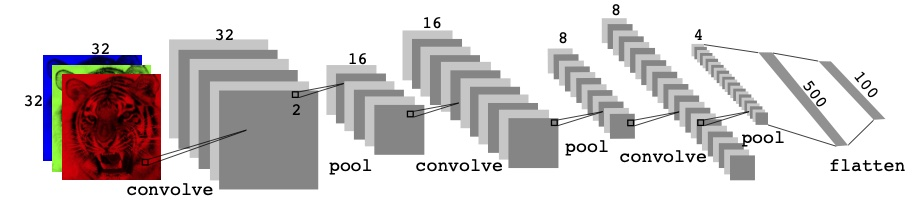

In summary, this is a deep CNN with four convolutional layers with RELU activations.

Each convolution is followed by max pooling layer, which reduces the size of the feature map in each channel by a factor of four: two in each dimension.

The feature map of the last convolution is flattened and dropout is applied for regularization.

Two fully-connected layers follow, and a softmax output layer. The model takes in a 3D input tensor and outputs a 1D tensor of shape (100,) representing the probabilities of each class.


In [ ]:
model = Sequential([
                layers.Input(shape=(32,32,3)),

                layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'),
                layers.MaxPooling2D(pool_size=(2,2)),

                layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
                layers.MaxPooling2D(pool_size=(2,2)),

                layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'),
                layers.MaxPooling2D(pool_size=(2,2)),

                layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same'),
                layers.MaxPooling2D(pool_size=(2,2)),

                layers.Flatten(),
                layers.Dropout(rate=0.5),

                layers.Dense(units=512, activation='relu'),

                layers.Dense(units=100, activation='softmax'),
                ])

model.summary()

Notice that we used the `padding = "same"` argument to
`Conv2D()`, which ensures that the output channels have the
same dimension as the input channels. There are 32 channels in the first
hidden layer, in contrast to the three channels in the input layer.


By studying the summary, we can see that the channels halve in both
dimensions after each of these max-pooling operations.

After the last of these we
have a layer with  256 channels of dimension $2\times 2$.

These are then
flattened to a dense layer of size 1,024:
in other words, each of the $2\times 2$ matrices is turned into a
$4$-vector, and put side-by-side in one layer.

This is followed by a
dropout regularization layer,  then
another dense layer of size 512, which finally reaches the softmax
output layer.


Finally, we specify the training configuration, and fit the model.

> ##### **Question**
>
> - How many weights and biases (trainable parameters) are there in this CNN? How does this compare with the feed forward model you created for MNIST?

#### Training configuration and model training
Here we will follow the same recipe as with the MNIST example.

Note that this will be a slow training process.

In [ ]:
# Training configuration

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Model training

history = model.fit(X_train,
                    y_train,
                    epochs=30,
                    # epochs=10,
                    batch_size=128,
                    validation_split=0.2)



306/313 [============================>.] - ETA: 3s - loss: 3.3209 - accuracy: 0.1962

In [ ]:
# Model evaluation on the test set!

eval_results = model.evaluate(X_test, y_test)
print("Test crossentropy loss:", eval_results[0])
print("Test accuracy:", eval_results[1])

This model takes 10 minutes to run and achieves 38-46% accuracy on the test
data. Although this is not terrible for 100-class data (a random
classifier gets 1% accuracy).


Searching the web, we see [results](https://benchmarks.ai/cifar-100) above 90%.

Typically it takes a lot of architecture carpentry,
fiddling with regularization, and time to achieve such results.

> ##### Question
>
> - Do you think that a feed forward network could also work well in the case of CIFAR? Explain why.


## 4. Pretrained CNN model for image classification

Training deep learning models is a challenging and time-cosnuming task that requires very big datasets, and deep architectures. Therefore, common deep learning models are made available along with their pre-trained parameters! This allows the AI community to reuse the models, for predictions in new applications.


[Keras Applications](https://keras.io/api/applications/) are deep learning models that are made available alongside pre-trained weights. These models can be used for prediction, feature extraction, and fine-tuning.


Below we will demonstrate how we use a CNN pretrained model to classify natural images. We will use ResNet50, and model that has been trained on the [ImageNet](https://www.image-net.org/) dataset. ImageNet is a large-scale image recognition dataset that was created in 2009. It is a widely used benchmark for evaluating the performance of image recognition algorithms, particularly convolutional neural networks (CNNs). The dataset contains over 14 million images, each of which is labeled with one of 21,841 categories.





We will show how to use a pre-trained ReNet50 model to produce *Figure 10.10*.

#### Load image examples
We copied six jpeg images from a digital photo album into the
directory `book_images`. We first read in the images a folder.
Then we convert them into the array format (256 x 256) to match the specifications in `imagenet` dateset.

In [ ]:
# Get book images
!wget -nc -q -P book_images https://git.wur.nl/koots006/msc-course-machine-learning/-/raw/main/islr_data/book_images/book_images/flamingo.jpg https://git.wur.nl/koots006/msc-course-machine-learning/-/raw/main/islr_data/book_images/book_images/hawk.jpg https://git.wur.nl/koots006/msc-course-machine-learning/-/raw/main/islr_data/book_images/book_images/hawk_cropped.jpeg https://git.wur.nl/koots006/msc-course-machine-learning/-/raw/main/islr_data/book_images/book_images/huey.jpg https://git.wur.nl/koots006/msc-course-machine-learning/-/raw/main/islr_data/book_images/book_images/kitty.jpg https://git.wur.nl/koots006/msc-course-machine-learning/-/raw/main/islr_data/book_images/book_images/weaver.jpg
img_dir = 'book_images/'

In [ ]:
#  browse the image directory and load the all the image names
img_names = []
for root, _, files in os.walk(img_dir):
    for file in files:
        if file.lower().endswith(('.jpg','.jpeg')):
            img_names.append(os.path.abspath(os.path.join(root, file)))

# save the number of images
num_img = len(img_names)


In [ ]:
# load all the images in a single array X,
# and keep all_images for visualization

X = np.ndarray(shape=(num_img, 224, 224, 3))
all_images = []

for i in range(num_img):
    img = keras.utils.load_img(img_names[i], target_size=(224, 224))
    all_images.append(img)
    x = keras.utils.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    X[i,:,:,:] = x

# preprocess the input for imagenet
X = preprocess_input(X)

Showing the 6 images:

In [ ]:
plt.figure(figsize=(8,12))
for i in range(num_img):
    plt.subplot(3,2,i+1)
    plt.imshow(all_images[i])
    plt.title(img_names[i])
plt.show()

#### Load the pretrained network
We load the trained network from the web! Keras provides this functionality, with a single line: `ResNet50(weights='imagenet')`, ie use the ResNet50 architecture with weights trained with ImageNet!

The model has 50 layers, with a fair bit of complexity.

If you want, print the model summary!

In [ ]:
model = ResNet50(weights='imagenet')
# model.summary()

#### Predict with own images
Loading the model was easy. Finally, we classify all our images, and return the top five (out of thousand) class
choices in terms of predicted probability for each.

In [ ]:
# predicts probability of each output class
predictions = model.predict(X)

# decode the predictions so that we see class names
# This is also supported from the imagenet_utils
decoded_preds = decode_predictions(predictions, top=5)
decoded_preds

Finally, visualize again the figures, together with the top-two predicted labels.




In [ ]:
# organize the labels
labels = [[f"""{decoded_preds[i][j][1]}({decoded_preds[i][j][2]:.2f})""" for j in range(2)] for i in range(num_img)]

# plot again the figures, with assigned labels
plt.figure(figsize=(10,20))
for i in range(num_img):
  plt.subplot(3,2,i+1)
  plt.imshow(all_images[i])
  plt.title(labels[i])
plt.show()

> **Discussion Question**
>
> - What do you think of the suggestions from the neural network? Do they make sense to you?
> - Is it confident when giving wrong labels?

> ##### ** Extra exercise**
>
> (optional if you have time at the end of today)
> - Repeat the above exercise with your own images, or images you download from the web! What do you think of ResNet50 performance?

## Summary
By now, you have mastered a lot with Neural Networks:
- You have learned how to create and train simple feed forward networks, and use them for regression and classification tasks.
- You have also trained your first convolutional neural network for classifying images.
- Last, you have reused a pre trained network, and applied it on your own data!

If you still have time, there is a data challenge for you below.

## Free style exercise: use all you know to get the best results on MNIST!

You have seen how to load MNIST and how to train CNNs.

Can you train a CNN that outperforms the Multilayer Network above in detecting handwritten numbers?

Report your [results online](https://app.wooclap.com/WURML)

In [ ]:
## TODO: Build and train your MNIST CNN here!